# 处理xlabeling标记好的数据，切图并且筛选可用的子图
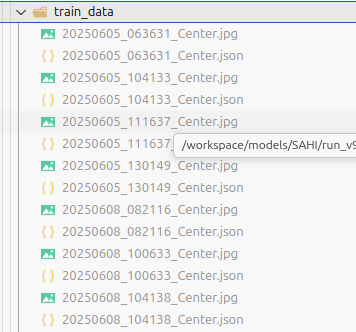

In [10]:
import os
import json
from tqdm import tqdm
import numpy as np
from sahi.slicing import slice_coco
from sahi.utils.file import load_json
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def labelme_to_coco(labelme_dir, output_json="dataset.json", annotation_type="polygon"):
    """
    将 LabelMe 格式标注合并为 COCO 格式
    :param labelme_dir: 存放 .json + .jpg 的目录
    :param output_json: 输出 COCO 格式路径
    :param annotation_type: 标注类型，"bbox" 或 "polygon"
    """
    print(f"Converting LabelMe annotations to COCO format ({annotation_type})...")
    
    if annotation_type not in ["bbox", "polygon"]:
        raise ValueError("annotation_type must be 'bbox' or 'polygon'")

    # 初始化 COCO 格式字段
    coco = {
        "info": {"description": f"Generated from LabelMe ({annotation_type})", "version": "1.0"},
        "licenses": [],
        "images": [],
        "annotations": [],
        "categories": []
    }

    label_to_id = {}
    ann_id = 1
    img_id = 1

    # 获取所有json文件
    json_files = [f for f in sorted(os.listdir(labelme_dir)) if f.endswith(".json")]
    
    for file in tqdm(json_files, desc="Processing JSON files"):
        json_path = os.path.join(labelme_dir, file)
        
        try:
            with open(json_path, "r", encoding="utf-8") as f:
                data = json.load(f)
        except Exception as e:
            print(f"Warning: Could not read {file}: {e}")
            continue

        # 图像基本信息
        image_filename = data.get("imagePath", file.replace(".json", ".jpg"))
        height = data.get("imageHeight")
        width = data.get("imageWidth")
        
        if height is None or width is None:
            print(f"Warning: Missing image dimensions in {file}, skipping...")
            continue

        # 添加到images列表
        coco["images"].append({
            "id": img_id,
            "width": width,
            "height": height,
            "file_name": image_filename,
        })

        # 处理每个shape
        for shape in data.get("shapes", []):
            label = shape["label"]
            shape_type = shape.get("shape_type", "").lower()
            points = np.array(shape["points"], dtype=np.float32)

            # 跳过无效的标注
            if len(points) < 2:
                continue

            # 处理类别
            if label not in label_to_id:
                label_id = len(label_to_id) + 1
                label_to_id[label] = label_id
                coco["categories"].append({
                    "id": label_id,
                    "name": label,
                    "supercategory": "none",
                })
            else:
                label_id = label_to_id[label]

            # 计算边界框（两种格式都需要）
            min_x = np.min(points[:, 0])
            min_y = np.min(points[:, 1])
            max_x = np.max(points[:, 0])
            max_y = np.max(points[:, 1])
            
            # 确保边界框坐标有效
            bbox_width = max_x - min_x
            bbox_height = max_y - min_y
            
            if bbox_width <= 0 or bbox_height <= 0:
                print(f"Warning: Invalid bbox in {file}, label: {label}")
                continue
                
            bbox = [float(min_x), float(min_y), float(bbox_width), float(bbox_height)]
            area = float(bbox_width * bbox_height)

            # 根据选择的标注类型处理
            if annotation_type == "bbox":
                # 只使用边界框，segmentation为空
                segmentation = []
                annotation_data = {
                    "id": ann_id,
                    "image_id": img_id,
                    "category_id": label_id,
                    "bbox": bbox,
                    "area": area,
                    "segmentation": segmentation,
                    "iscrowd": 0,
                }
                
            else:  # polygon
                # 根据shape_type处理多边形
                if shape_type == "rectangle":
                    # 矩形转为多边形 [x1, y1, x2, y1, x2, y2, x1, y2]
                    x1, y1 = min_x, min_y
                    x2, y2 = max_x, max_y
                    segmentation = [[
                        float(x1), float(y1),
                        float(x2), float(y1), 
                        float(x2), float(y2),
                        float(x1), float(y2)
                    ]]
                elif shape_type == "polygon":
                    # 多边形直接使用所有点
                    segmentation = [points.flatten().tolist()]
                elif shape_type == "circle":
                    # 圆形近似为多边形（16个点）
                    center_x = (min_x + max_x) / 2
                    center_y = (min_y + max_y) / 2
                    radius_x = (max_x - min_x) / 2
                    radius_y = (max_y - min_y) / 2
                    segmentation = []
                    circle_points = []
                    for i in range(16):
                        angle = 2 * np.pi * i / 16
                        x = center_x + radius_x * np.cos(angle)
                        y = center_y + radius_y * np.sin(angle)
                        circle_points.extend([float(x), float(y)])
                    segmentation.append(circle_points)
                else:
                    # 其他未知类型，默认按多边形处理
                    segmentation = [points.flatten().tolist()]
                
                annotation_data = {
                    "id": ann_id,
                    "image_id": img_id,
                    "category_id": label_id,
                    "bbox": bbox,
                    "area": area,
                    "segmentation": segmentation,
                    "iscrowd": 0,
                }

            coco["annotations"].append(annotation_data)
            ann_id += 1

        img_id += 1

    # 验证结果
    if len(coco["images"]) == 0:
        print("Warning: No valid images found!")
        return
    
    if len(coco["annotations"]) == 0:
        print("Warning: No valid annotations found!")

    # 保存结果
    with open(output_json, "w", encoding="utf-8") as f:
        json.dump(coco, f, indent=2, ensure_ascii=False)
        
    print(f"\n✅ Conversion completed!")
    print(f"Output: {output_json}")
    print(f"Annotation type: {annotation_type}")
    print(f"Total images: {len(coco['images'])}")
    print(f"Total annotations: {len(coco['annotations'])}")
    print(f"Classes ({len(label_to_id)}): {list(label_to_id.keys())}")



In [11]:
# # 使用bbox格式
# labelme_to_coco(
#     "/workspace/models/SAHI/run_v9/train_data", 
#     "/workspace/models/SAHI/run_v9/train_data/dataset_bbox.json",
#     annotation_type="bbox"
# )

# # 使用polygon格式（默认）
# labelme_to_coco(
#     "/workspace/models/SAHI/run_v9/train_data", 
#     "/workspace/models/SAHI/run_v9/train_data/dataset_polygon.json",
#     annotation_type="polygon"
# )

# 实际使用
# 使用polygon格式（默认）
images_folder = "/workspace/models/SAHI/run_v9/ElderFarm1_0625_autofocus_rpicam_still"
output_json_path = "/workspace/models/SAHI/run_v9/temp/dataset_polygon.json"
output_sliced_folder = "/workspace/models/SAHI/run_v9/temp/sliced_output/"
labelme_to_coco(
    images_folder, 
    output_json_path,
    annotation_type="bbox"
)

Converting LabelMe annotations to COCO format (bbox)...


Processing JSON files: 100%|██████████| 28/28 [00:00<00:00, 23923.51it/s]


✅ Conversion completed!
Output: /workspace/models/SAHI/run_v9/temp/dataset_polygon.json
Annotation type: bbox
Total images: 28
Total annotations: 38
Classes (2): ['swd', 'swd2']


In [ ]:
coco_dict, coco_path = slice_coco(
    coco_annotation_file_path=output_json_path,
    image_dir=images_folder,
    output_coco_annotation_file_name=output_sliced_folder,
    ignore_negative_samples=False,
    output_dir=output_sliced_folder,
    slice_height=640,
    slice_width=640,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2,
    min_area_ratio=1,
    verbose=True
)

  0%|          | 0/28 [00:00<?, ?it/s]2025-10-23 05:44:59,913 - sahi - INFO - image.shape: (9248, 6944) (slicing.py:322)
2025-10-23 05:45:00,130 - sahi - INFO - Num slices: 252 slice_height: 640 slice_width: 640 (slicing.py:396)
  4%|▎         | 1/28 [00:00<00:16,  1.63it/s]2025-10-23 05:45:00,181 - sahi - INFO - sliced image path: /workspace/models/SAHI/run_v9/temp/sliced_output/20250605_060125_Center_0_1536_0_2176_640.png (slicing.py:314)
2025-10-23 05:45:00,196 - sahi - INFO - sliced image path: /workspace/models/SAHI/run_v9/temp/sliced_output/20250605_060125_Center_0_1024_0_1664_640.png (slicing.py:314)
2025-10-23 05:45:00,203 - sahi - INFO - sliced image path: /workspace/models/SAHI/run_v9/temp/sliced_output/20250605_060125_Center_0_3072_0_3712_640.png (slicing.py:314)
2025-10-23 05:45:00,203 - sahi - INFO - sliced image path: /workspace/models/SAHI/run_v9/temp/sliced_output/20250605_060125_Center_0_0_0_640_640.png (slicing.py:314)
2025-10-23 05:45:00,204 - sahi - INFO - sliced im

2025-10-23 05:46:04,983 - sahi - INFO - sliced image path: /workspace/models/SAHI/run_v9/temp/sliced_output/20250621_115147_Center_27_512_512_1152_1152.png (slicing.py:314)
2025-10-23 05:46:05,015 - sahi - INFO - sliced image path: /workspace/models/SAHI/run_v9/temp/sliced_output/20250621_115147_Center_27_6656_0_7296_640.png (slicing.py:314)
2025-10-23 05:46:05,021 - sahi - INFO - sliced image path: /workspace/models/SAHI/run_v9/temp/sliced_output/20250619_082127_Center_26_1536_2048_2176_2688.png (slicing.py:314)
2025-10-23 05:46:05,022 - sahi - INFO - sliced image path: /workspace/models/SAHI/run_v9/temp/sliced_output/20250621_115147_Center_27_3584_0_4224_640.png (slicing.py:314)
2025-10-23 05:46:05,027 - sahi - INFO - sliced image path: /workspace/models/SAHI/run_v9/temp/sliced_output/20250621_115147_Center_27_6144_0_6784_640.png (slicing.py:314)
2025-10-23 05:46:05,028 - sahi - INFO - sliced image path: /workspace/models/SAHI/run_v9/temp/sliced_output/20250619_071122_Center_25_6144_

In [13]:
import os
import json
import shutil
from pathlib import Path
import yaml
from tqdm import tqdm

def filter_and_convert_sliced_coco(sliced_coco_path, sliced_image_dir, output_dir, 
                                 annotation_type='bbox', yolo_format=True, create_del_folder=True,
                                 min_annotation_area=0, max_annotation_area=float('inf'),
                                 min_area_ratio=0.0, max_area_ratio=1.0):
    """
    筛选切片后的COCO数据并转换为YOLO格式
    
    :param sliced_coco_path: 切片后的COCO注解文件路径
    :param sliced_image_dir: 切片后的图像目录
    :param output_dir: 输出目录
    :param annotation_type: 标注类型，'bbox'或'seg'
    :param yolo_format: 是否转换为YOLO格式
    :param create_del_folder: 是否创建_del文件夹存放无标注图像
    :param min_annotation_area: 最小标注面积（像素）
    :param max_annotation_area: 最大标注面积（像素）
    :param min_area_ratio: 最小面积比例（相对于图像面积）
    :param max_area_ratio: 最大面积比例（相对于图像面积）
    """
    
    print("🔍 Filtering sliced COCO data and converting to YOLO format...")
    print(f"📏 Area filtering parameters:")
    print(f"  • Min annotation area: {min_annotation_area} pixels")
    print(f"  • Max annotation area: {max_annotation_area} pixels")
    print(f"  • Min area ratio: {min_area_ratio}")
    print(f"  • Max area ratio: {max_area_ratio}")
    print(f"  • Annotation type: {annotation_type}")
    
    # 验证标注类型参数
    if annotation_type not in ['bbox', 'seg']:
        raise ValueError("annotation_type must be 'bbox' or 'seg'")
    
    # 读取切片后的COCO注解
    with open(sliced_coco_path, 'r', encoding='utf-8') as f:
        coco_data = json.load(f)
    
    # 创建输出目录
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # 创建_del文件夹（如果需要）
    del_dir = output_dir / "_del"
    if create_del_folder:
        del_dir.mkdir(exist_ok=True)
    
    # 构建图像ID到文件名的映射
    image_id_to_file = {img['id']: img['file_name'] for img in coco_data['images']}
    image_id_to_size = {img['id']: (img['width'], img['height']) for img in coco_data['images']}
    
    # 构建类别映射
    categories = {cat['id']: cat['name'] for cat in coco_data['categories']}
    category_id_to_index = {cat_id: idx for idx, cat_id in enumerate(categories.keys())}
    
    # 过滤标注（基于面积）
    filtered_annotations = []
    area_filtered_count = 0
    
    for ann in tqdm(coco_data['annotations'], desc="Filtering annotations by area"):
        image_id = ann['image_id']
        image_width, image_height = image_id_to_size[image_id]
        image_area = image_width * image_height
        
        # 根据标注类型计算面积
        if annotation_type == 'bbox':
            ann_area = ann['area']
        else:  # segmentation
            # 对于分割标注，如果有area字段就使用，否则计算
            if 'area' in ann:
                ann_area = ann['area']
            else:
                # 简化的面积计算（实际应该使用多边形面积计算）
                # 这里使用边界框面积作为近似
                bbox = ann['bbox']
                ann_area = bbox[2] * bbox[3]
        
        area_ratio = ann_area / image_area
        
        # 检查面积条件
        if (min_annotation_area <= ann_area <= max_annotation_area and 
            min_area_ratio <= area_ratio <= max_area_ratio):
            filtered_annotations.append(ann)
        else:
            area_filtered_count += 1
    
    # 统计每个图像的标注数量（过滤后）
    image_annotations = {}
    for ann in filtered_annotations:
        image_id = ann['image_id']
        if image_id not in image_annotations:
            image_annotations[image_id] = []
        image_annotations[image_id].append(ann)
    
    # 分离有标注和无标注的图像
    images_with_annotations = []
    images_without_annotations = []
    
    for image in coco_data['images']:
        image_id = image['id']
        if image_id in image_annotations and len(image_annotations[image_id]) > 0:
            images_with_annotations.append(image)
        else:
            images_without_annotations.append(image)
    
    print(f"\n📊 Sliced Data Statistics:")
    print(f"  • Total sliced images: {len(coco_data['images'])}")
    print(f"  • Images with annotations: {len(images_with_annotations)}")
    print(f"  • Images without annotations: {len(images_without_annotations)}")
    print(f"  • Total original annotations: {len(coco_data['annotations'])}")
    print(f"  • Filtered annotations: {len(filtered_annotations)}")
    print(f"  • Area-filtered annotations: {area_filtered_count}")
    print(f"  • Categories: {list(categories.values())}")
    
    # 显示面积统计
    if filtered_annotations:
        areas = []
        for ann in filtered_annotations:
            if annotation_type == 'bbox':
                areas.append(ann['area'])
            else:
                if 'area' in ann:
                    areas.append(ann['area'])
                else:
                    bbox = ann['bbox']
                    areas.append(bbox[2] * bbox[3])
        
        print(f"  • Min annotation area: {min(areas):.2f} pixels")
        print(f"  • Max annotation area: {max(areas):.2f} pixels")
        print(f"  • Avg annotation area: {sum(areas)/len(areas):.2f} pixels")
    
    # 处理无标注图像（移动到_del文件夹）
    if create_del_folder and images_without_annotations:
        print(f"\n🗑️  Moving {len(images_without_annotations)} images without annotations to _del folder...")
        for image in tqdm(images_without_annotations, desc="Moving images"):
            src_path = Path(sliced_image_dir) / image['file_name']
            dst_path = del_dir / image['file_name']
            if src_path.exists():
                shutil.move(str(src_path), str(dst_path))
    
    # 更新COCO数据（只保留有标注的图像和过滤后的标注）
    filtered_coco_data = {
        "images": images_with_annotations,
        "annotations": filtered_annotations,
        "categories": coco_data["categories"]
    }
    
    # 保存过滤后的COCO注解
    filtered_coco_path = output_dir / "filtered_sliced_coco.json"
    with open(filtered_coco_path, 'w', encoding='utf-8') as f:
        json.dump(filtered_coco_data, f, indent=2, ensure_ascii=False)
    
    print(f"✅ Filtered COCO annotations saved to: {filtered_coco_path}")
    
    # 转换为YOLO格式
    if yolo_format:
        convert_to_yolo_format(filtered_coco_data, sliced_image_dir, output_dir, 
                             categories, category_id_to_index, annotation_type)
    
    return filtered_coco_path

def convert_to_yolo_format(coco_data, image_dir, output_dir, categories, category_id_to_index, annotation_type):
    """
    将COCO格式转换为YOLO格式
    
    :param annotation_type: 标注类型，'bbox'或'seg'
    """
    print(f"\n🔄 Converting to YOLO format ({annotation_type})...")
    
    # 创建YOLO目录结构
    yolo_dir = output_dir / "yolo_format"
    images_dir = yolo_dir / "images"
    labels_dir = yolo_dir / "labels"
    
    images_dir.mkdir(parents=True, exist_ok=True)
    labels_dir.mkdir(parents=True, exist_ok=True)
    
    # 构建图像ID到标注的映射
    image_annotations = {}
    for ann in coco_data['annotations']:
        image_id = ann['image_id']
        if image_id not in image_annotations:
            image_annotations[image_id] = []
        image_annotations[image_id].append(ann)
    
    # 处理每个图像
    processed_count = 0
    for image in tqdm(coco_data['images'], desc="Converting to YOLO"):
        image_id = image['id']
        image_file = image['file_name']
        image_width = image['width']
        image_height = image['height']
        
        # 复制图像到YOLO images目录
        src_image_path = Path(image_dir) / image_file
        dst_image_path = images_dir / image_file
        
        # 检查源文件是否存在（可能已被移动到_del）
        if src_image_path.exists():
            shutil.copy2(src_image_path, dst_image_path)
        else:
            # 检查是否在_del文件夹中（有标注的图像不应该在_del中）
            possible_del_path = output_dir / "_del" / image_file
            if possible_del_path.exists():
                print(f"⚠️  Warning: Image {image_file} is in _del but has annotations!")
                shutil.copy2(possible_del_path, dst_image_path)
            else:
                print(f"⚠️  Warning: Image {image_file} not found, skipping...")
                continue
        
        # 创建YOLO标签文件
        label_file = Path(image_file).with_suffix('.txt')
        label_path = labels_dir / label_file
        
        with open(label_path, 'w', encoding='utf-8') as f:
            if image_id in image_annotations:
                for ann in image_annotations[image_id]:
                    # 获取类别索引
                    category_id = ann['category_id']
                    class_index = category_id_to_index[category_id]
                    
                    if annotation_type == 'bbox':
                        # YOLO边界框格式
                        bbox = ann['bbox']  # [x, y, width, height]
                        x_center = (bbox[0] + bbox[2] / 2) / image_width
                        y_center = (bbox[1] + bbox[3] / 2) / image_height
                        width = bbox[2] / image_width
                        height = bbox[3] / image_height
                        
                        # 写入YOLO格式：class x_center y_center width height
                        f.write(f"{class_index} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
                    
                    else:  # segmentation
                        # YOLO分割格式
                        segmentation = ann['segmentation']
                        
                        # 处理多个多边形的情况（COCO允许多个多边形表示一个对象）
                        all_polygons = []
                        if isinstance(segmentation, list):
                            for poly in segmentation:
                                # 将多边形坐标归一化
                                normalized_poly = []
                                for i in range(0, len(poly), 2):
                                    x = poly[i] / image_width
                                    y = poly[i+1] / image_height
                                    normalized_poly.extend([x, y])
                                all_polygons.append(normalized_poly)
                        
                        # 写入YOLO分割格式：class x1 y1 x2 y2 ... 
                        for poly in all_polygons:
                            poly_str = " ".join([f"{coord:.6f}" for coord in poly])
                            f.write(f"{class_index} {poly_str}\n")
        
        processed_count += 1
    
    # 创建数据集YAML文件
    create_yolo_yaml_file(yolo_dir, categories, category_id_to_index, images_dir, annotation_type)
    
    print(f"✅ YOLO format conversion completed!")
    print(f"  • YOLO directory: {yolo_dir}")
    print(f"  • Images: {images_dir}")
    print(f"  • Labels: {labels_dir}")
    print(f"  • Processed images: {processed_count}")
    print(f"  • Annotation type: {annotation_type}")

def create_yolo_yaml_file(yolo_dir, categories, category_id_to_index, images_dir, annotation_type):
    """
    创建YOLO数据集配置文件
    """
    yaml_path = yolo_dir / "dataset.yaml"
    
    # 构建类别名称列表（按索引排序）
    class_names = [""] * len(categories)
    for cat_id, cat_name in categories.items():
        class_index = category_id_to_index[cat_id]
        class_names[class_index] = cat_name
    
    yaml_data = {
        'path': str(yolo_dir.absolute()),  # 数据集根目录
        'train': str(images_dir.absolute()),  # 训练图像目录
        'val': str(images_dir.absolute()),    # 验证图像目录（与训练相同）
        
        'nc': len(categories),  # 类别数量
        'names': class_names,   # 类别名称列表
        'annotation_type': annotation_type  # 标注类型
    }
    
    with open(yaml_path, 'w', encoding='utf-8') as f:
        yaml.dump(yaml_data, f, default_flow_style=False, allow_unicode=True)
    
    print(f"📁 YOLO dataset config saved to: {yaml_path}")

def analyze_annotation_areas(coco_path, annotation_type='bbox'):
    """
    分析标注面积分布，帮助确定合适的面积阈值
    
    :param annotation_type: 标注类型，'bbox'或'seg'
    """
    print("📊 Analyzing annotation area distribution...")
    
    with open(coco_path, 'r', encoding='utf-8') as f:
        coco_data = json.load(f)
    
    areas = []
    area_ratios = []
    
    for ann in coco_data['annotations']:
        image_id = ann['image_id']
        image = next(img for img in coco_data['images'] if img['id'] == image_id)
        image_area = image['width'] * image['height']
        
        # 根据标注类型计算面积
        if annotation_type == 'bbox':
            ann_area = ann['area']
        else:  # segmentation
            if 'area' in ann:
                ann_area = ann['area']
            else:
                bbox = ann['bbox']
                ann_area = bbox[2] * bbox[3]
        
        areas.append(ann_area)
        area_ratios.append(ann_area / image_area)
    
    if areas:
        print(f"Area Statistics (pixels):")
        print(f"  Min: {min(areas):.2f}")
        print(f"  Max: {max(areas):.2f}")
        print(f"  Mean: {sum(areas)/len(areas):.2f}")
        print(f"  Median: {sorted(areas)[len(areas)//2]:.2f}")
        
        print(f"\nArea Ratio Statistics:")
        print(f"  Min: {min(area_ratios):.6f}")
        print(f"  Max: {max(area_ratios):.6f}")
        print(f"  Mean: {sum(area_ratios)/len(area_ratios):.6f}")
        print(f"  Median: {sorted(area_ratios)[len(area_ratios)//2]:.6f}")
        
        # 显示分位数
        for p in [0.1, 0.25, 0.5, 0.75, 0.9]:
            area_p = sorted(areas)[int(len(areas) * p)]
            ratio_p = sorted(area_ratios)[int(len(area_ratios) * p)]
            print(f"  {int(p*100)}%: {area_p:.2f} pixels, {ratio_p:.6f} ratio")


In [14]:
# # 使用边界框标注
# filter_and_convert_sliced_coco(
#     sliced_coco_path="/workspace/models/SAHI/run_v9/train_data_sliced/_coco.json",
#     sliced_image_dir="/workspace/models/SAHI/run_v9/train_data_sliced/",
#     output_dir="/workspace/models/SAHI/run_v9/train_data_sliced_output_bbox",
#     annotation_type='bbox',  # 使用边界框
#     yolo_format=True
# )

# 使用分割标注
filter_and_convert_sliced_coco(
    sliced_coco_path=f"{output_sliced_folder}/_coco.json",
    sliced_image_dir=output_sliced_folder,
    output_dir=f"{output_sliced_folder}/train_data_sliced_output_seg",
    annotation_type='bbox',  # 使用分割
    yolo_format=True
)

# # 分析标注面积
# analyze_annotation_areas("sliced_coco.json", annotation_type='bbox')

🔍 Filtering sliced COCO data and converting to YOLO format...
📏 Area filtering parameters:
  • Min annotation area: 0 pixels
  • Max annotation area: inf pixels
  • Min area ratio: 0.0
  • Max area ratio: 1.0
  • Annotation type: bbox


Filtering annotations by area: 100%|██████████| 45/45 [00:00<00:00, 346318.68it/s]



📊 Sliced Data Statistics:
  • Total sliced images: 7056
  • Images with annotations: 44
  • Images without annotations: 7012
  • Total original annotations: 45
  • Filtered annotations: 45
  • Area-filtered annotations: 0
  • Categories: ['swd', 'swd2']
  • Min annotation area: 5366.00 pixels
  • Max annotation area: 13733.00 pixels
  • Avg annotation area: 10130.36 pixels

🗑️  Moving 7012 images without annotations to _del folder...


Moving images: 100%|██████████| 7012/7012 [00:03<00:00, 2256.46it/s]


✅ Filtered COCO annotations saved to: /workspace/models/SAHI/run_v9/temp/sliced_output/train_data_sliced_output_seg/filtered_sliced_coco.json

🔄 Converting to YOLO format (bbox)...


Converting to YOLO: 100%|██████████| 44/44 [00:00<00:00, 155.21it/s]


⚠️  Warning: Image 20250621_115147_Center_27_6656_5632_7296_6272.png not found, skipping...
📁 YOLO dataset config saved to: /workspace/models/SAHI/run_v9/temp/sliced_output/train_data_sliced_output_seg/yolo_format/dataset.yaml
✅ YOLO format conversion completed!
  • YOLO directory: /workspace/models/SAHI/run_v9/temp/sliced_output/train_data_sliced_output_seg/yolo_format
  • Images: /workspace/models/SAHI/run_v9/temp/sliced_output/train_data_sliced_output_seg/yolo_format/images
  • Labels: /workspace/models/SAHI/run_v9/temp/sliced_output/train_data_sliced_output_seg/yolo_format/labels
  • Processed images: 43
  • Annotation type: bbox


PosixPath('/workspace/models/SAHI/run_v9/temp/sliced_output/train_data_sliced_output_seg/filtered_sliced_coco.json')